In [ ]:
%pip install pandas
%pip install boto3
%pip install psycopg2
%pip install sqlalchemy
%pip install dotenv


%pip matplotlib
%pip plotly
%pip seaborn 


# Run this cell to install these packages
# !pip install pandas boto3 sqlalchemy python-dotenv

In [1]:
# Import dependencies
import boto3
import os
import pandas as pd
from sqlalchemy import create_engine, text
import psycopg2
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import plotly.express as px
import plotly.graph_objects as go


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors





#pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

sns.set(style="whitegrid")

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Load environment variables from .env file
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

True

# <h2 align="center">Data Input</h2>


### Define a Function to Query & Display Results

In [2]:
# Create a function to fetch data from the database
def get_db_connection():
    db_url = (
        f"postgresql://{os.environ['DB_USER']}:{os.environ['DB_PASSWORD']}@"
        f"{os.environ['DB_HOST']}:{os.environ['DB_PORT']}/{os.environ['DB_NAME']}"
    )
    return create_engine(db_url)

# Instantiate the database connection
engine = get_db_connection()


# Define query to fetch data from each table
query_clinics = "SELECT * FROM clinics;"
query_patients = "SELECT * FROM patients;"
query_sessions = "SELECT * FROM sessions;"
query_feedback = "SELECT * FROM feedback;"
query_dropout_flags = "SELECT * FROM dropout_flags;"
query_interventions = "SELECT * FROM interventions;"

# Load data from each table into a DataFrame
clinics_df = pd.read_sql(query_clinics, engine)
patients_df = pd.read_sql(query_patients, engine)
sessions_df = pd.read_sql(query_sessions, engine)
feedback_df = pd.read_sql(query_feedback, engine)
dropout_flags_df = pd.read_sql(query_dropout_flags, engine)
interventions_df = pd.read_sql(query_interventions, engine)

### Feature Engineering
- Create New features
- Merge relevant datasets

## NOTE: 
After the EDA, the data is pretty messy, hence we will:
- define the `patients data and session data` and merge the data together followed by, 
- creating a pipeline (define numerical and categorical columns),
- Then preprocessing the data before doing the clustering,
- Then do the clustering,

## Patient Segmentation:
To see which cluster each patient belong to, to see the behaviour of how each patient behave in each cluster

### Steps:
    - Define the patients(who they are i.e the features)
    - Define patients sessions

- Defining patients/sessions

In [35]:
#  Define the sessions and the patients had in regards to the therapy (Extra Features Engineering) i.e The Dynamic dataset
sess_agg = (
    sessions_df
    .sort_values(['patient_id', 'date']) #Put all patient session in calender mode(To have a sorted data set that gives all patients id's with the dates).
    .assign(pain_delta=lambda d: (d.groupby('patient_id')['pain_level'].diff() #Create a new column to help save change in new pain level(transform/standardize the sorted data, assigning a particulae condition(lambda) to new columns with the diff.)
    ))
    .groupby('patient_id') #Group by patient_id, (collect all the rows belonging to each patient)
    .agg(
        n_sessions = ('session_id', 'count'), # Defining extra insightss into the session data
        avg_session_duration = ('duration', 'mean'),
        first_week = ('week', 'min'),
        last_week = ('week', 'max'),
        mean_pain = ('pain_level', 'mean'),
        mean_pain_level_delta = ('pain_delta', 'mean'),
        home_adherence_mean = ('home_adherence_pc', 'mean'),
        satisfaction_mean = ('satisfaction', 'mean')
    )
)

In [36]:
sess_agg.head(2)

,n_sessions,avg_session_duration,first_week,last_week,mean_pain,mean_pain_level_delta,home_adherence_mean,satisfaction_mean
patient_id,,,,,,,,
1,20,41.750,1,12,2.15,-0.263158,77.750,6.5
2,8,33.875,1,11,2.25,-0.571429,61.625,7.0


In [37]:
# Define patients (a static data i.e informations about patient that does not change around segmenting the data
patient_sel = patients_df.set_index('patient_id')
patient_sel.head(2)

,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type,age_group,gender_binary,age_capped,bmi_capped
patient_id,,,,,,,,,,,,,,,
1,29,Male,23.9,0,Diabetes,Knee,2025-04-27 00:12:44.286283,Insurance,1,6,Public,19-30,0,29,23.9
2,68,Female,31.7,1,Diabetes,Shoulder,2024-11-28 00:12:44.286283,Insurance,0,3,Public,56-75,1,68,31.7


In [38]:
# Join the static and dynamic dataset together (For behavioural feature)
patient_session_df = patient_sel.join(sess_agg, how='left')
patient_session_df.head(2)

,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,...,age_capped,bmi_capped,n_sessions,avg_session_duration,first_week,last_week,mean_pain,mean_pain_level_delta,home_adherence_mean,satisfaction_mean
patient_id,,,,,,,,,,,,,,,,,,,,,
1,29,Male,23.9,0,Diabetes,Knee,2025-04-27 00:12:44.286283,Insurance,1,6,...,29,23.9,20,41.750,1,12,2.15,-0.263158,77.750,6.5
2,68,Female,31.7,1,Diabetes,Shoulder,2024-11-28 00:12:44.286283,Insurance,0,3,...,68,31.7,8,33.875,1,11,2.25,-0.571429,61.625,7.0


#### Augment the `patient_session_df` with more datasets.

In [39]:
dropout_flags_df.head(1)

,patient_id,dropout,session_count,session_count_capped
0,1,0,4,4


In [ ]:
patients_df.columns

In [40]:
# Labelling data, (engineering and encoding) Reason is for encoding

# Patient static attributes, defines what describe the patient.
patient_sel = patients_df[
    ["patient_id",
    "age",
    "gender",
    "bmi",
    "smoker",
    "chronic_cond",
    "injury_type",
    "referral_source",
    "insurance_type"
    ]
].set_index("patient_id")

# Label Engineering (attache the dropout_flags_df to patients)
# Label will be use as source of truth later in prediction (who dropped out or not)

# Do the labels; to know who the data said dropout durring the sesion, to know why.
label = dropout_flags_df.set_index("patient_id").dropout

In [41]:
patient_session_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1 to 5000
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   age                    5000 non-null   int64         
 1   gender                 5000 non-null   object        
 2   bmi                    5000 non-null   float64       
 3   smoker                 5000 non-null   int64         
 4   chronic_cond           5000 non-null   object        
 5   injury_type            5000 non-null   object        
 6   signup_date            5000 non-null   datetime64[ns]
 7   referral_source        5000 non-null   object        
 8   consent                5000 non-null   int64         
 9   clinic_id              5000 non-null   int64         
 10  insurance_type         5000 non-null   object        
 11  age_group              5000 non-null   category      
 12  gender_binary          5000 non-null   int64         
 13  age_capp

In [ ]:
patient_session_df.select_dtypes(include='number').corr()

In [73]:
print(patient_session_df.select_dtypes(include='number').corr())

                            age       bmi    smoker   consent  clinic_id  \
age                    1.000000  0.007534  0.020084 -0.010325  -0.004561   
bmi                    0.007534  1.000000  0.699317 -0.493306   0.009591   
smoker                 0.020084  0.699317  1.000000 -0.501600   0.018760   
consent               -0.010325 -0.493306 -0.501600  1.000000  -0.014899   
clinic_id             -0.004561  0.009591  0.018760 -0.014899   1.000000   
gender_binary          0.009686 -0.019925 -0.009729  0.036531   0.018262   
age_capped             1.000000  0.007534  0.020084 -0.010325  -0.004561   
bmi_capped             0.007672  0.999794  0.699272 -0.490759   0.009931   
n_sessions            -0.009220 -0.296598 -0.400830  0.307081  -0.008440   
avg_session_duration  -0.006669  0.011603  0.004855 -0.003793   0.004283   
first_week            -0.002073  0.170385  0.210386 -0.192853  -0.005805   
last_week              0.006767 -0.151832 -0.203501  0.175372   0.012341   
mean_pain   

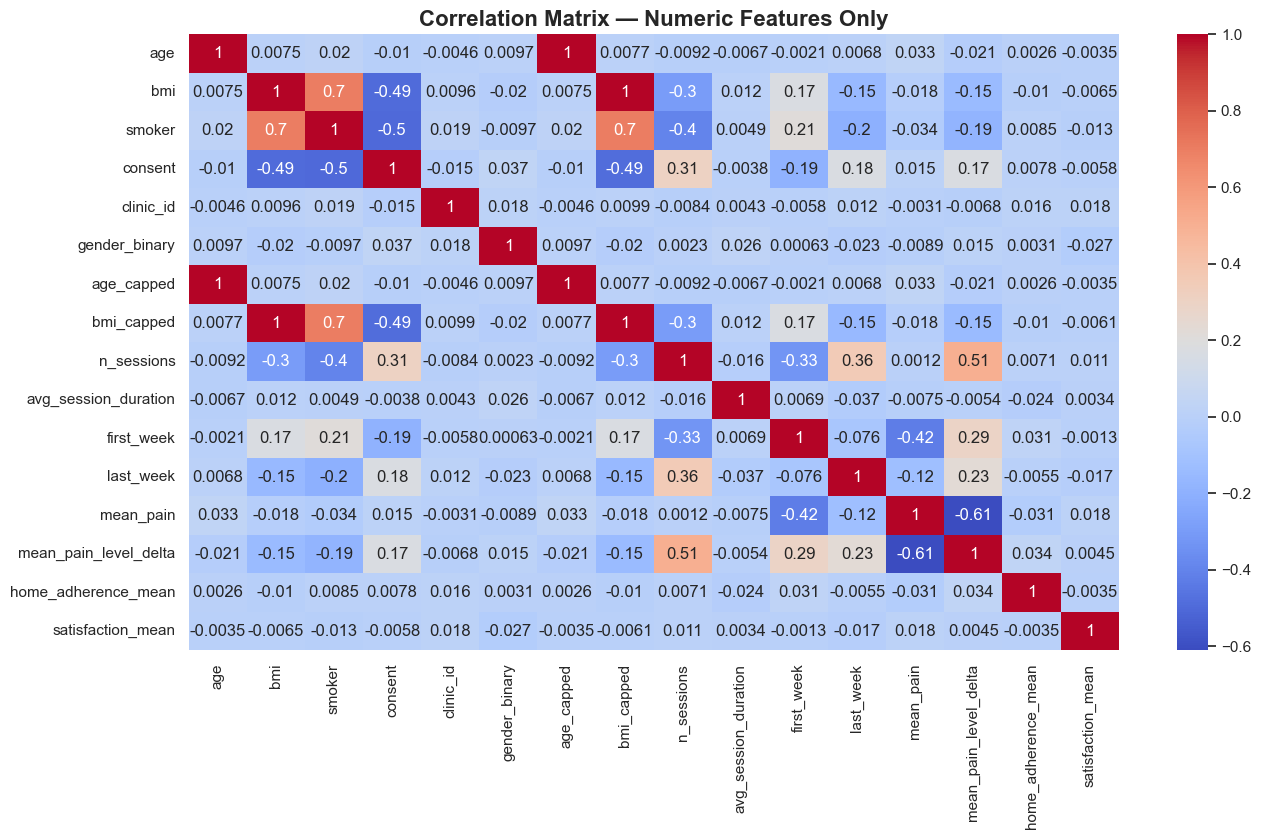

In [47]:
corr = patient_session_df.select_dtypes(include='number').corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix — Numeric Features Only', fontsize=16, fontweight='bold')
plt.show()

In [ ]:
# Manual Dimension reduction, this is as a result of Correllation Analysis

# Define Data Pipeline - Compress all data processing step into one pipeline

# - Define numeric Columns and Categorical Columns.

# Look out for high dimensions in the data
# Lookout for density in the data.

num_cols = [  # ensure to use correlation analysis to guide choice of features.
    "age", "bmi",
    "n_sessions", "avg_session_duration", 
    "mean_pain", "mean_pain_level_delta"
]

cat_cols = [
    "gender", "smoker", 
    "chronic_cond", "injury_type"
]

In [49]:
patient_session_df.columns

Index(['age', 'gender', 'bmi', 'smoker', 'chronic_cond', 'injury_type',
       'signup_date', 'referral_source', 'consent', 'clinic_id',
       'insurance_type', 'age_group', 'gender_binary', 'age_capped',
       'bmi_capped', 'n_sessions', 'avg_session_duration', 'first_week',
       'last_week', 'mean_pain', 'mean_pain_level_delta',
       'home_adherence_mean', 'satisfaction_mean'],
      dtype='object')

In [51]:
patient_session_df[cat_cols].astype("string")  # casting categorical data

,gender,smoker,chronic_cond,injury_type
patient_id,,,,
1,Male,0,Diabetes,Knee
2,Female,1,Diabetes,Shoulder
3,Male,0,Diabetes,Hip
4,Female,0,Diabetes,Back
5,Female,0,Diabetes,Shoulder
...,...,...,...,...
4996,Female,1,Diabetes,Back
4997,Female,0,Diabetes,Shoulder
4998,Female,0,Diabetes,Back


In [ ]:
#patient_session_df[num_cols].astype(float)

In [52]:
## Preprocessing the pipeline(to help compress...)

numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scalar", RobustScaler())
    ]
)
categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]
)

In [53]:
# Column Transformer, # Apply the pipeline and transform everthing
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ]
)

print(type(preprocess))

<class 'sklearn.compose._column_transformer.ColumnTransformer'>


In [54]:
# Model the data
X_preprocess = preprocess.fit_transform(patient_session_df)

In [55]:
X_preprocess

array([[-0.64705882, -0.22641509,  1.5       , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.5       ,  1.24528302, -1.5       , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38235294,  0.45283019,  0.75      , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.08823529, -0.32075472,  0.75      , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.97058824,  0.67924528,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.55882353,  0.18867925,  0.5       , ...,  0.        ,
         0.        ,  0.        ]], shape=(5000, 20))

In [58]:
# Auto dimension reduction;  the Concept used is the PCA

# PCA to help retain the variance of features while reducing the dimensionality of data
pca = PCA(n_components=0.85, random_state=42) # n_components i.e number of components is the percent of variance to maintain

# Attache the PCA to the data into a new data, to result to reduced variance.
X_reduced = pca.fit_transform(X_preprocess)
X_reduced

array([[ 9.97283785e-01, -7.50226913e-01,  2.92391335e-01, ...,
        -5.07128488e-01,  5.52343120e-02,  7.01406806e-01],
       [-2.63588963e+00,  8.33660434e-01, -1.15697063e+00, ...,
        -1.70124963e-01,  4.68401752e-01, -7.25424765e-01],
       [-1.77140974e-03, -5.28081875e-01,  2.16781598e-01, ...,
        -1.50430322e-01, -1.08867944e-01, -1.60489651e-01],
       ...,
       [ 1.29883388e+00, -1.06053945e-01, -3.97423778e-01, ...,
         7.57247040e-01,  9.19115077e-02,  1.41197114e-01],
       [ 4.69676539e-01,  4.77400272e-02,  7.63879564e-02, ...,
        -5.83524105e-01,  1.12741470e-01,  6.40036614e-01],
       [ 6.62736742e-01,  1.64217442e-01, -4.06409464e-01, ...,
        -9.96352576e-02,  1.75619644e-01, -1.75729538e-01]],
      shape=(5000, 9))

#### Observation:
X_reduced is now a properly cleaned data, hence we choose the algorithm, to sample either of:
- K-means
- Hierarchical clustering
- DBSCAN
- HBSCAN

### Clustering
- Define K-means; then check in the following:
    - ELbow
    - silhouette_score
    - choose k and get cluster
    - Do DBSCAN
    - PCAN
    - Answer Dropout Questions("fast_improver", "steady progresser", "frustrated_droppers")

In [60]:
# DBSCAN(Algortithm that is density based): Applying to the X_reduced (cleaned data)

# Define the DBSCAN algorithm
eps = 1.5           # What should be the Distance between each patient in a cluster...i.e the core points
min_samples = 3     # Define the Minimium number of border points i.e surrounding core points
db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_reduced)
db_labels = db.labels_  # labels -1 are noise points .ie the outliers, far away from core points


# filtered valid points or clusters (excluded the noise points)
valid_labels = db_labels != -1 # Remove for the one that is the last point...

# Now How well are this cluster formed? are they properly formed?,
# Check the SILHOUTEE, i.e Check the shape, is it properly shaped?

# Calculate the silhoutee score

# The Rule of Thumb:
# silhoutee score should be between 1, 0, 0r -1;
# If score is above 0 and close to 1, cluster in good shape
# If score is 0 cluster good but could be improved
# If score is below 0 and close to -1 cluster bad and not in good shape


# The silhoutee score
# Check to see based on eps/min_sample, can a cluster be derived out of the sample?
# When atleast a cluster is found, give the silhoutee score.

if valid_labels.sum() > 1 :
    sil_db = silhouette_score(X_reduced[valid_labels], db_labels[valid_labels])
    print(f"DBSCAN VALID CLUSTER Silhoutee score {sil_db:.3f}")
else:
    print(f"Not enough cluster to be derived")

DBSCAN VALID CLUSTER Silhoutee score 0.441


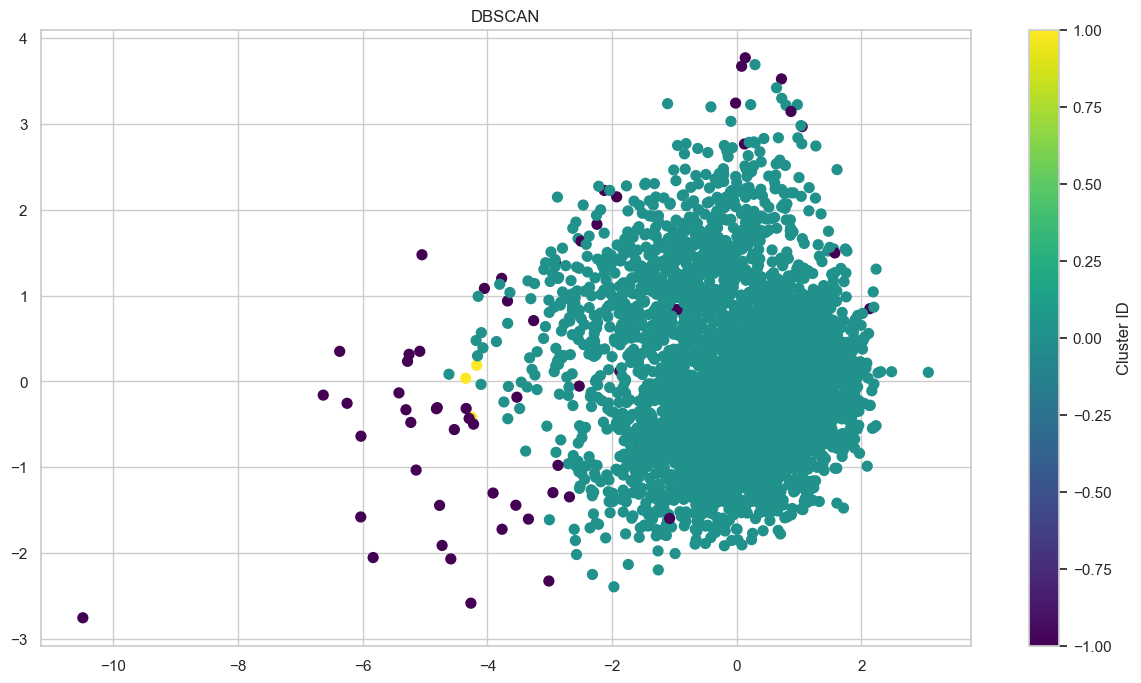

In [62]:
# Plot DBSCAN
plt.figure(figsize=(15, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=db_labels, cmap='viridis', s=50)
plt.colorbar(label="Cluster ID")
plt.title("DBSCAN")
plt.show()

In [ ]:
#db = DBSCAN(eps=2.3, min_samples=4).fit(X_reduced)
#db_labels = db.labels_
#sil_db = silhouette_score(X_reduced[db_labels != -1],
                          #db_labels[db_labels != -1])
#print(f"DBSCAN VALID CLUSTER SILHOUTEE: {sil_db:.3f}")

In [ ]:
# DBSCAN -------- catch any extra outliers
#knn = NearestNeighbors(n_neighbors=4).fit(X_preprocess)
#dists = np.sort(knn.kneighbors(X_preprocess)[0][:,-1])
#plt.figure(figsize=(15, 8)); plt.plot(dists, 'o-'); pl 
# t.title("4-NN distance - choose E"); plt.show()

### Observation:
This shows the data is overlapping 
The reason is because
       - The data does not have equal density, some data are more densed than others.
       - The data is not uniformly distributed.e.g age not equally densed...

What to do:
Use the Kmeans algorithm to group data into meaningful clusters.

#### Clust_ready = preprocess

#### Define k,to group patients into meaningful personas

steps:
- loop through a range of k (assumptions)
- plot the elbow
- plot the silhoutee
- decision making and choosing of k

In [63]:
def k_search(X, k_range=range(2, 11)):
    wcss = []  # Within-cluster sum of squares
    sils = []  # Silhouette scores

    for k in k_range:               # loop through the range of k
        km = KMeans(
            n_clusters=k,
            init="k-means++",       # first centroid start apart
            n_init="auto",
            random_state=42,
            algorithm="lloyd"  #  'lloyd'
        )
        preds = km.fit_predict(X)   # runs the algorithm and returns a cluster id for each patient
        wcss.append(km.inertia_)       # Elbows tension inside cluster aka rubber band effect
        sils.append(silhouette_score(X, preds))  # 'silhoutte_score' seperate and compact each point 

    return wcss, sils

In [64]:
# K-Means On the:
X_reduced

array([[ 9.97283785e-01, -7.50226913e-01,  2.92391335e-01, ...,
        -5.07128488e-01,  5.52343120e-02,  7.01406806e-01],
       [-2.63588963e+00,  8.33660434e-01, -1.15697063e+00, ...,
        -1.70124963e-01,  4.68401752e-01, -7.25424765e-01],
       [-1.77140974e-03, -5.28081875e-01,  2.16781598e-01, ...,
        -1.50430322e-01, -1.08867944e-01, -1.60489651e-01],
       ...,
       [ 1.29883388e+00, -1.06053945e-01, -3.97423778e-01, ...,
         7.57247040e-01,  9.19115077e-02,  1.41197114e-01],
       [ 4.69676539e-01,  4.77400272e-02,  7.63879564e-02, ...,
        -5.83524105e-01,  1.12741470e-01,  6.40036614e-01],
       [ 6.62736742e-01,  1.64217442e-01, -4.06409464e-01, ...,
        -9.96352576e-02,  1.75619644e-01, -1.75729538e-01]],
      shape=(5000, 9))

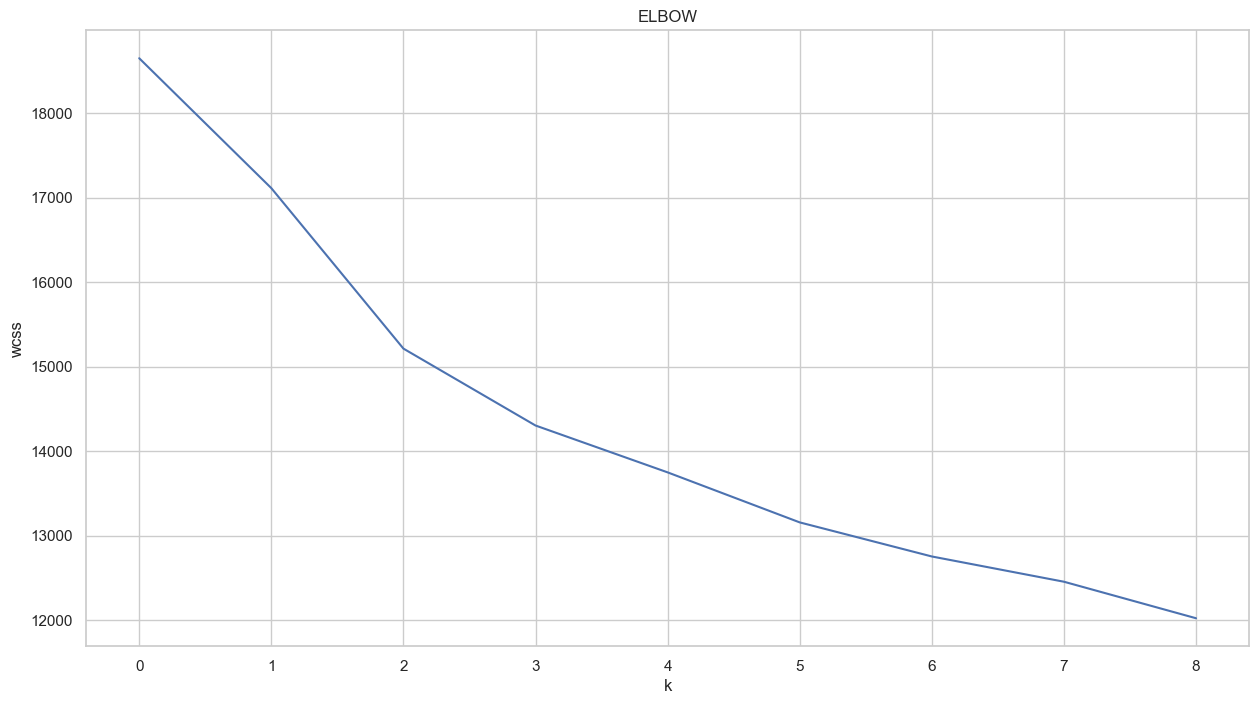

In [65]:
# Plot Elbow and silhoutte
wcss, sils = k_search(X_reduced)
plt.figure(figsize=(15,8))
plt.plot(wcss)
plt.title('ELBOW')
plt.xlabel('k')
plt.ylabel('wcss')
plt.show()

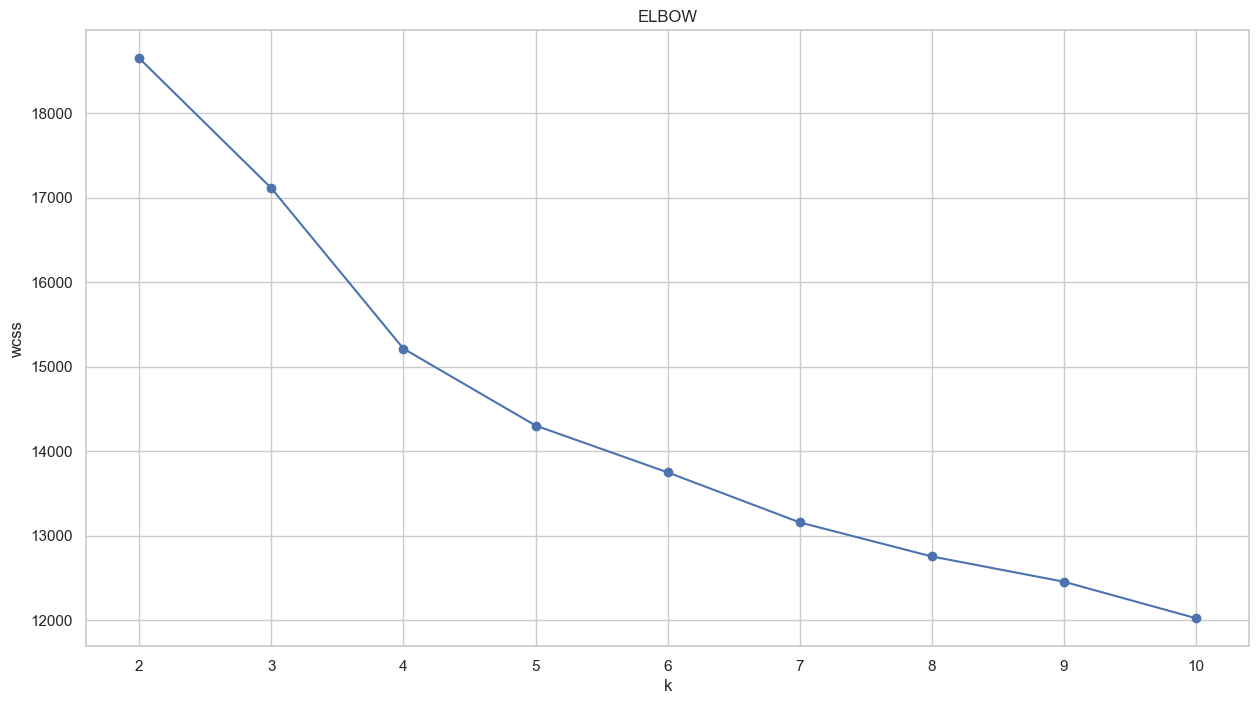

In [66]:
# Plot Elbow and silhoutte
wcss, sils = k_search(X_reduced)
plt.figure(figsize=(15,8)); plt.plot(range(2,11), wcss, 'o-')
plt.title('ELBOW')
plt.xlabel('k')
plt.ylabel('wcss')
plt.show()

Text(0, 0.5, 'silhoutee score')

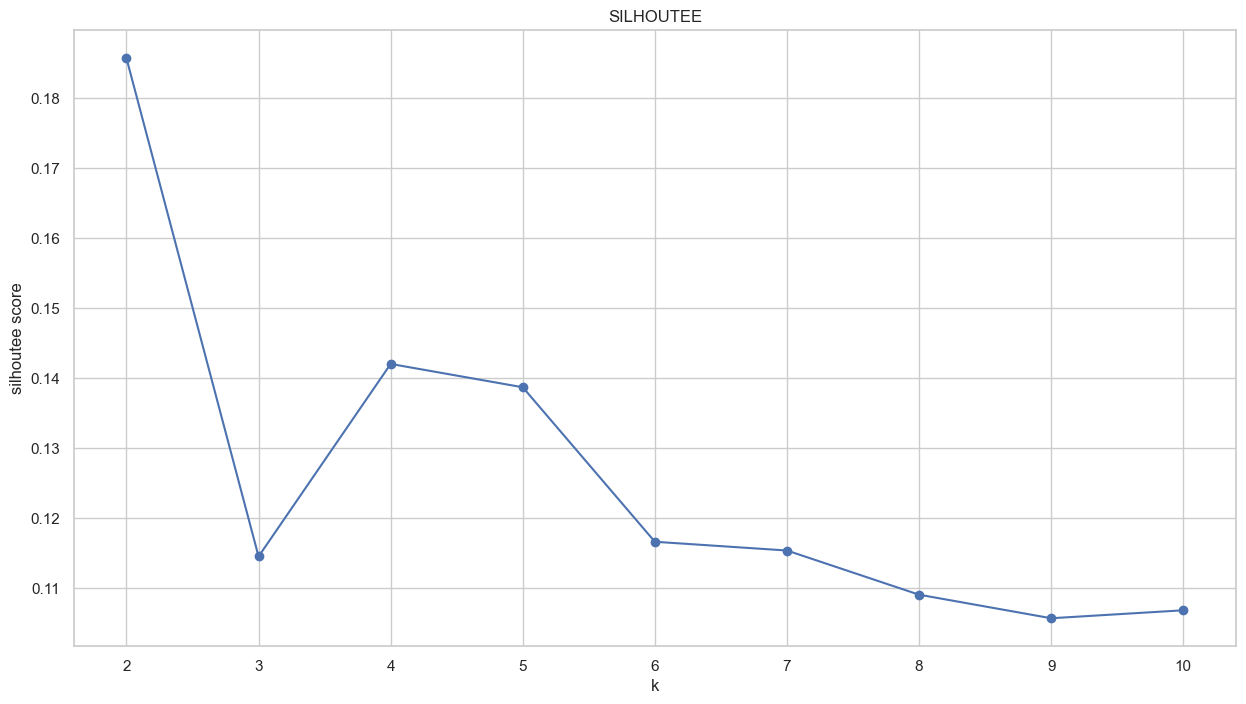

In [68]:
# The Silhoutee
plt.figure(figsize=(15,8)); plt.plot(range(2,11), sils, 'o-')
plt.title('SILHOUTEE')
plt.xlabel('k')
plt.ylabel('silhoutee score')

In [ ]:
# Rule of thumb: pick the smallest k past the elbow and hows silhoutee closer to the KPI (business >=0.6)

In [ ]:
# choose k = k

k_OPT = 3
k_means = KMeans(
    n_clusters=k_OPT,
    n_init="auto",
    random_state=42,
    algorithm="lloyd" 
)
clusters = k_means.fit_predict(X_reduced)

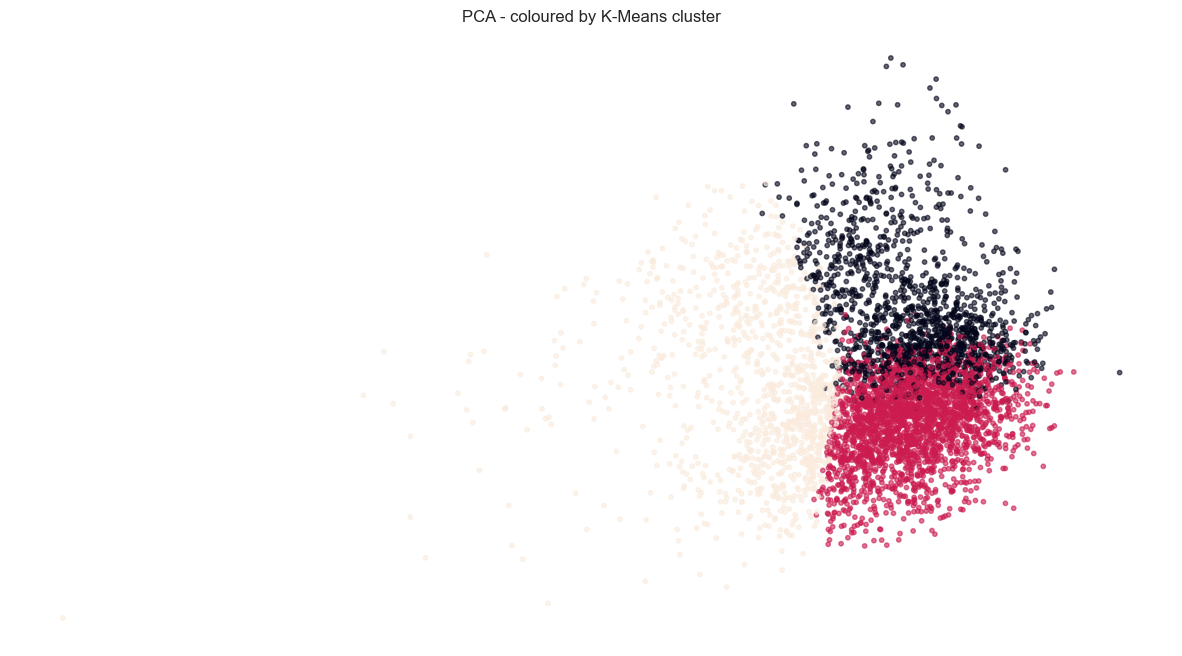

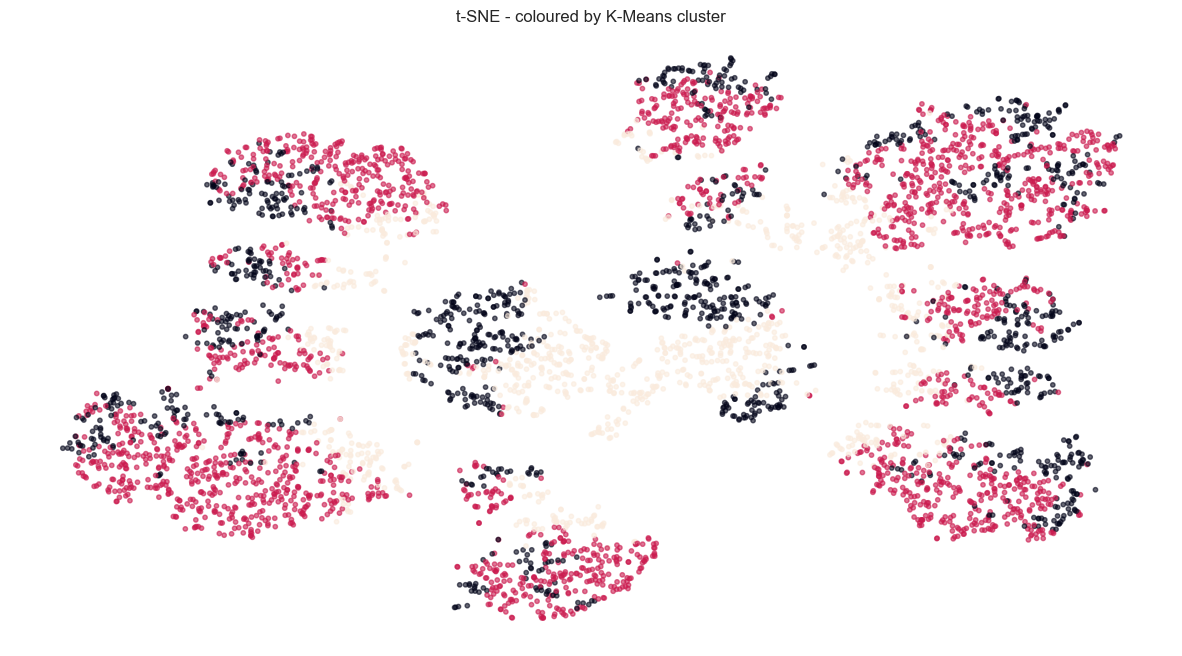

In [70]:
# PCA/t-SNE visual

pca2 = PCA(n_components=2, random_state=42).fit_transform(X_reduced)
tsne2 = TSNE(n_components=2, perplexity=40,
             init="pca", random_state=42).fit_transform(X_reduced)


def scatter_2d(mat, labels, title):
    plt.figure(figsize=(15, 8))
    plt.scatter(mat[:, 0], mat[:, 1], c=labels, alpha=0.6, s=10)
    plt.title(title),
    plt.axis("off")

scatter_2d(pca2, clusters, "PCA - coloured by K-Means cluster")
scatter_2d(tsne2, clusters, "t-SNE - coloured by K-Means cluster")

### Observation:
- PCA (2d dimensional view) shows Proper clusters i.e Optimal clusters
- t-SNE(More Zoomed in) shows that clusters distinct, thier still some overlapping clusters... Need optimization to be better.